# Exploring Reversal in Crypto

Exploring optimization of the Directional Index Strategy. For more details, see project README.md!

In [5]:
from binance.client import Client as bnb_client
import statsmodels.api as sm
from datetime import datetime
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [6]:
# # Get all USDT trading pairs - Uncomment to download and save to pickle

# client = bnb_client(tld='US')

# def get_binance_px(symbol,freq,start_ts = '2020-01-01'):
#     data = client.get_historical_klines(symbol,freq,start_ts)
#     columns = ['open_time','open','high','low','close','volume','close_time','quote_volume',
#     'num_trades','taker_base_volume','taker_quote_volume','ignore']

#     data = pd.DataFrame(data,columns = columns)
    
#     # Convert from POSIX timestamp (number of millisecond since jan 1, 1970)
#     data['open_time'] = data['open_time'].map(lambda x: datetime.utcfromtimestamp(x/1000))
#     data['close_time'] = data['close_time'].map(lambda x: datetime.utcfromtimestamp(x/1000))
#     return data 
# # Fetch all trading pairs
# exchange_info = client.get_exchange_info()

# # Extract all symbols that end with "USDT"
# univ = [symbol['symbol'] for symbol in exchange_info['symbols'] if symbol['quoteAsset'] == 'USDT']

# freq = '1h' #technically a period
# px = {}
# vol = {}
# high = {}
# low = {}
# for x in univ:
#     data = get_binance_px(x,freq)
#     px[x] = data.set_index('open_time')['close']
#     vol[x] = data.set_index('open_time')['volume']
#     high[x] = data.set_index('open_time')['high']
#     low[x] = data.set_index('open_time')['low']


# px = pd.DataFrame(px).astype(float)
# px = px.reindex(pd.date_range(px.index[0],px.index[-1],freq=freq))

# vol = pd.DataFrame(vol).astype(float)
# vol = vol.reindex(pd.date_range(vol.index[0],vol.index[-1],freq=freq))

# high = pd.DataFrame(high).astype(float)
# high = high.reindex(pd.date_range(high.index[0],high.index[-1],freq=freq))

# low = pd.DataFrame(low).astype(float)
# low = low.reindex(pd.date_range(low.index[0],low.index[-1],freq=freq))

# ret = px.pct_change()

# Save to pickle to avoid long download
# px.to_pickle('full_usdt_df_'+ freq+'_px.pkl')
# ret.to_pickle('full_usdt_df_'+ freq+'_ret.pkl')
# vol.to_pickle('full_usdt_df_'+ freq+'_vol.pkl')
# high.to_pickle('full_usdt_df_'+ freq+'_high.pkl')
# low.to_pickle('full_usdt_df_'+ freq+'_low.pkl')

In [7]:
# Load data
px = pd.read_pickle('full_usdt_df_1d_px.pkl') #change file based on frequency
ret = pd.read_pickle('full_usdt_df_1d_ret.pkl') #change file based on frequency
vol = pd.read_pickle('full_usdt_df_1d_vol.pkl') #change file based on frequency
high = pd.read_pickle('full_usdt_df_1d_high.pkl') #change file based on frequency
low = pd.read_pickle('full_usdt_df_1d_low.pkl') #change file based on frequency

In [19]:
# Keep high price-volume coins for master security
price_vol = px.mean()*vol.mean()

threshold = 100_000
big_coins = price_vol[price_vol > threshold].index

ret_big = ret[big_coins]

In [20]:
# Create a returns object

class returns:

    """Returns object:
       
       Given a portfolio of signals (port) and percent returns of a security (ret), this will output common metrics and variables used in
       performance evaluation and analysis.

       The purify() method performs a linear regression and extracts the residual from that regression. Pass in the appropriate beta for
       your regression.
       """
    
    def __init__(self, port, ret):
        self.port = port
        self.ret = ret

    # Normalize portfolio, usually done before gen_returns()
    def norm(self):
        self.port = self.port.divide(self.port.abs().sum(1),0)#.fillna(0) # normalize rows

    # Calculate returns and evaluation metrics
    def gen_returns(self, tcost_bps=20, N_trades = 365, print_results=True):
        self.gross_ret = (self.port.shift()*self.ret).sum(1)
        self.to = (self.port - self.port.shift()).abs().sum(1)
        self.mean_tcost = self.to.mean()*tcost_bps*1e-4
        self.net_ret = self.gross_ret.subtract(self.to*tcost_bps*1e-4,fill_value=0)
        self.mean_gross = self.gross_ret.mean()
        
        if print_results:
            print("Mean gross returns:", self.mean_gross,
             "\nMean tcosts:", self.mean_tcost,
             "\nMean net returns:", self.net_ret.mean(),
             "\nGross Sharpe:", self.gross_ret.mean()/self.gross_ret.std()*np.sqrt(N_trades), 
             "\nNet Sharpe:", self.net_ret.mean()/self.net_ret.std()*np.sqrt(N_trades),
             "\nMean turnover:", self.to.mean())

    # Purify strategy: Does linear regression on chosen beta and outputs alpha and information ratio
    def purify(self, beta, N_trades = 365, print_results=True):
        Y = self.net_ret
        X = beta
        X = sm.add_constant(X)
        
        results = sm.OLS(Y, X).fit()
        self.alpha = results.params['const'] + results.resid
        self.ir = self.alpha.mean()/self.alpha.std()*np.sqrt(N_trades)
        
        if print_results:
            print("params:",
            '\n',results.params,
            "\nt-values:", 
            '\n',results.tvalues,
            '\nInfo Ratio:', self.ir)



In [21]:
# Define average functions

# Simple moving average
def sma(asset_df, avg_time):
    return asset_df.rolling(window=avg_time).mean()

# Exponential (weighted) moving average
def ema(asset_df, alpha):
    return asset_df.ewm(alpha=alpha, adjust=False).mean()   


## Try basket pairs trading
- When divergence in price is sufficiently large, trade.
    - Exit when divergence drops.
    - Use highly correlated coins

In [32]:
# Function to perform rolling regression

"""Can't use df.rolling(), only accepts scalar. Below is a multivariate multiple regression with a single coin as the 
independent variable and all other coins in the universe as dependent variables. Also finds correlation in rolling window
and only includes those coins."""

def rolling_regression(df, indep_var, window, corr_thresh=0.7):
    results = []
    consts = []
    
    # Manual rolling window regression
    for start in range(len(df) - window + 1):
        window_df = df.iloc[start:start + window]  
        X = window_df[indep_var].fillna(0)
        X = sm.add_constant(X)  
        Y = window_df.drop(columns=[indep_var]).fillna(0)
        corrs = window_df.corr().loc[indep_var].drop(indep_var)
        model = sm.OLS(Y, X).fit()
        beta_row = model.params.loc[indep_var].copy()   
        const_row = model.params.loc['const'].copy()     
        
        # For coins whose rolling correlation is below threshold, set regression outputs to 0
        for coin in beta_row.index:
            if abs(corrs.iloc[coin]) < corr_thresh:
                beta_row[coin] = 0   
                const_row[coin] = 0 
                
        results.append(beta_row)
        consts.append(const_row)
        
    betas = pd.DataFrame(results, index=df.index[window-1:])
    betas.columns = Y.columns
    consts = pd.DataFrame(consts, index=df.index[window-1:])
    consts.columns = Y.columns
    
    independent = df[indep_var].iloc[window:]
    dep_vars = df.drop(columns=[indep_var]).iloc[window:]
    
    return {'betas': betas, 'consts': consts, 'indep var':independent, 'dep vars':dep_vars}


In [33]:
# Pairs trade signal generation function

def pairs_trade(sec, basket, betas, threshold=1):

    # Calculate residual of basket and target sec and threshold reversal trades
    diff = basket - betas.multiply(sec,axis=0)
    pos_diff = diff > diff.rolling(100).std()*threshold
    neg_diff = diff < -1*diff.rolling(100).std()*threshold

    # Make df of longs (1's) and shorts (-1's)
    signal = pd.DataFrame(0,index=basket.index, columns=basket.columns)
    signal = diff.mask(pos_diff, -1).mask(neg_diff, 1)
    return signal


# Pairs trade function but smooths residual with EMA
def pairs_trade_smooth(sec, basket, betas, threshold=1, alpha = 0.5):

    # Calculate residual of basket and target sec and threshold reversal trades
    diff = ema(basket - betas.multiply(sec,axis=0), alpha)
    pos_diff = diff > diff.rolling(100).std()*threshold
    neg_diff = diff < -1*diff.rolling(100).std()*threshold

    # Make df of longs (1's) and shorts (-1's)
    signal = pd.DataFrame(0,index=basket.index, columns=basket.columns)
    signal = diff.mask(pos_diff, -1).mask(neg_diff, 1)
    return signal



In [34]:
# Do rolling reg. In separate cell because its a bit slow
window = 30
roll_reg = rolling_regression(ret.fillna(0), 'BTCUSDT', window)

Mean gross returns: 0.0046754719470925256 
Mean tcosts: 0.0030098795192242136 
Mean net returns: 0.0017108655119230328 
Gross Sharpe: 3.3899270004043656 
Net Sharpe: 1.251512071400512 
Mean turnover: 1.5049397596121066
params: 
 const      0.001685
BTCUSDT    0.014060
dtype: float64 
t-values: 
 const      2.827997
BTCUSDT    0.796205
dtype: float64 
Info Ratio: 1.2326531070527285


<Axes: title={'center': 'Alpha: BTC Rolling Reg Pairs Trade'}>

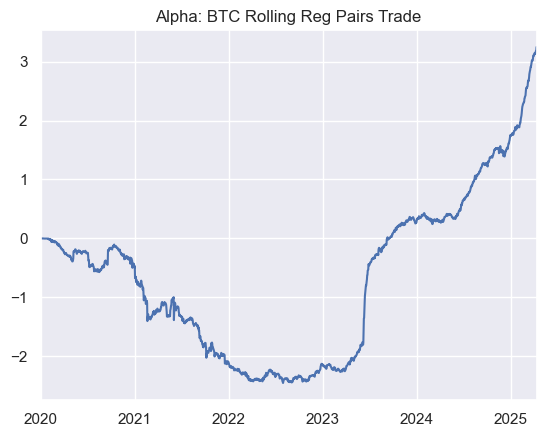

In [35]:
# Set up pairs trading example

ret = ret
sec = roll_reg['indep var']
betas = roll_reg['betas']
basket = roll_reg['dep vars']

# Make signal
port = pairs_trade(sec,basket,betas,threshold=1.5)
port['BTCUSDT'] = -1*port.sum(1)  #add ind var back in, making dollar neutral

# Get results
rets = returns(port, ret)
rets.norm()
rets.gen_returns()

beta = ret['BTCUSDT'].fillna(0)
rets.purify(beta)

rets.alpha.cumsum().plot(title='Alpha: BTC Rolling Reg Pairs Trade')


## Implement Directional Index to Predict Reversal

In [36]:
# Directional index equations

def di_trend(high, low, close, alpha):

    # Positive directional movement
    pos_dm_condition = (high - high.shift(-1) > low.shift(-1) - low) & (high > high.shift(-1))
    pos_dm = (high - high.shift(-1)).where(pos_dm_condition, 0)

    # Negative directional movement
    neg_dm_condition = (high - high.shift(-1) < low.shift(-1) - low) & (low < low.shift(-1))
    neg_dm = (low.shift(-1) - low).where(neg_dm_condition, 0)

    # True Range
    hl = high - low
    hc = (high - close.shift(-1)).abs()
    cl = (close.shift(-1) - low).abs()   
    stacked = np.stack([hl.values, hc.values, cl.values], axis=0)
    tr = np.max(stacked, axis=0)
    tr = pd.DataFrame(tr, index=high.index, columns=high.columns)

    # Average directional index
    atr = ema(tr, alpha)
    pdi = ema(pos_dm, alpha)/atr
    ndi = ema(neg_dm, alpha)/atr

    di = (pdi-ndi).abs()/(pdi+ndi)
    di_sign = np.sign(pdi-ndi)

    return di, di_sign

In [37]:
# Make trend crossing functions

def trend_crossing(asset, fit, trend, threshold=0.3):
    
    diff = (asset - fit)/fit

    # Detect trend crossing with sign change and threshold on crossing strength and direction
    cross = diff.where(diff.shift()*diff < 0)
    cross = cross.where(trend.abs() >= threshold) 
    cross = cross.mask(cross > 0, 1).mask(cross < 0, -1)
    cross.ffill(inplace=True)  # Forward fill to maintain previous value
    
    return cross.fillna(0)


In [43]:
# Make training set

# Use high market cap coins for target security, but trade on all coins.
ret_train = ret.copy()
train_cols = ret_train.columns
high_train = high[train_cols]
low_train = low[train_cols]
close_train = px[train_cols]
master_sec_train = ret_big.columns[np.random.randint(0,ret_big.shape[1])] #Choose random big cap



Mean gross returns: 0.0012370366827339965 
Mean tcosts: 0.00019615299423388568 
Mean net returns: 0.0010438341225420104 
Gross Sharpe: 2.629224423053917 
Net Sharpe: 2.251654141833957 
Mean turnover: 0.09807649711694284
params: 
 const      0.001041
LTCUSDT    0.001847
dtype: float64 
t-values: 
 const      5.157638
LTCUSDT    0.441141
dtype: float64 
Info Ratio: 2.2457813709947705


<Axes: title={'center': 'Alpha: Directional Index Signal'}>

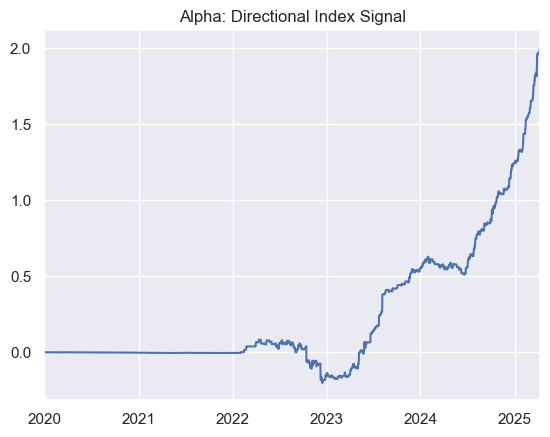

In [44]:
# Reversal Strategy
window = 30
roll_reg = rolling_regression(ret_train, master_sec_train, window)

alpha = 0.35 
di = di_trend(high_train, low_train, close_train, alpha)

# M/R sig threshold
thresh = 1/4
mr_sig = ((di[0]*di[1]).diff().sum(1)).abs()
sig_thresh = np.max(mr_sig)*thresh

# Reversal components
sec = roll_reg['indep var']
betas = roll_reg['betas']
basket = roll_reg['dep vars']

# Reversal signal
rev_port = pairs_trade(sec, basket, betas, threshold=1.5)
rev_port = rev_port.where(mr_sig > sig_thresh, 0)
rev_port[master_sec_train] = -1*rev_port.sum(1)

rets = returns(rev_port, ret_train)
rets.norm()
rets.gen_returns()

beta = ret[master_sec_train].fillna(0)
rets.purify(beta)

rets.alpha.cumsum().plot(title='Alpha: Directional Index Signal')


## Slow down reversal signal

Compare with smoothed residual

Mean gross returns: 0.0010928997653084703 
Mean tcosts: 0.00012804453604650702 
Mean net returns: 0.0009667812103539488 
Gross Sharpe: 2.339129897808652 
Net Sharpe: 2.088067569833172 
Mean turnover: 0.0640222680232535
params: 
 const      0.000966
LTCUSDT    0.000347
dtype: float64 
t-values: 
 const      4.792855
LTCUSDT    0.083015
dtype: float64 
Info Ratio: 2.0869447493775097


<Axes: title={'center': 'Alpha: Directional Index Signal'}>

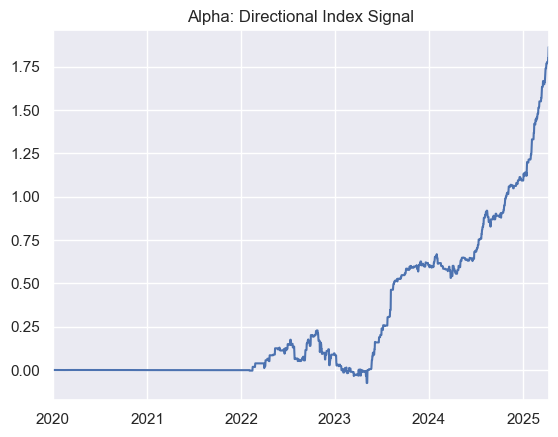

In [45]:
# Reversal Strategy - smoothed
window = 30
roll_reg = rolling_regression(ret_train, master_sec_train, window)

alpha = 0.35 
di = di_trend(high_train, low_train, close_train, alpha)

# M/R sig threshold
thresh = 1/4
mr_sig = ((di[0]*di[1]).diff().sum(1)).abs()
sig_thresh = np.max(mr_sig)*thresh

sec = roll_reg['indep var']
betas = roll_reg['betas']
basket = roll_reg['dep vars']

rev_port = pairs_trade_smooth(sec, basket, betas, threshold=1.5, alpha = 0.2)
rev_port = rev_port.where(mr_sig > sig_thresh, 0)
rev_port[master_sec_train] = -1*rev_port.sum(1)

rets = returns(rev_port, ret)
rets.norm()
rets.gen_returns()

beta = ret[master_sec_train].fillna(0)
rets.purify(beta)

rets.alpha.cumsum().plot(title='Alpha: Directional Index Signal')


In [46]:
# Make training set

# ret_train = ret.sample(n=20, axis=1, random_state=42).fillna(0)
# ret_train = ret_big.fillna(0)
ret_train = ret.fillna(0)
train_cols = ret_train.columns
high_train = high[train_cols].fillna(0)
low_train = low[train_cols].fillna(0)
close_train = px[train_cols].fillna(0)
master_sec = ret_big.columns[np.random.randint(0,ret_big.shape[1])]

In [47]:
# # Explore performance on remaining data set using othe master coins

## UNCOMMENT TO RUN - LONG RUN TIME

# #### Reversal ####

# window = 30

# # Make trend signal
# alpha = 0.35 #often 1/(day average), can be optimized
# di = di_trend(high_train,low_train,close_train,alpha)

# info_rats = []

# # M/R sig threshold
# thresh = 0.3
# mr_sig = ((di[0]*di[1]).diff().sum(1)).abs()
# sig_thresh = np.max(mr_sig)*thresh

# for col in ret_big.columns:
#     roll_reg = rolling_regression(ret_train, col, window)

#     # Reversal components
#     sec = roll_reg['indep var']
#     betas = roll_reg['betas']
#     basket = roll_reg['dep vars']

#     # Reversal signal
#     rev_port = pairs_trade_smooth(sec, basket, betas, threshold=1.5)
#     rev_port = rev_port.where(mr_sig > sig_thresh, 0)
#     rev_port[master_sec] = -1*rev_port.sum(1)

#     rets = returns(rev_port, ret_train)
#     rets.norm()
#     rets.gen_returns(print_results=False)
#     beta = ret_train[master_sec].fillna(0)
#     rets.purify(beta, print_results=False)
#     info_rats.append(rets.ir)


# # rets.alpha.cumsum().plot(title='Alpha: Reversal Strategy')
# # ret_train[master_sec].cumsum().plot()

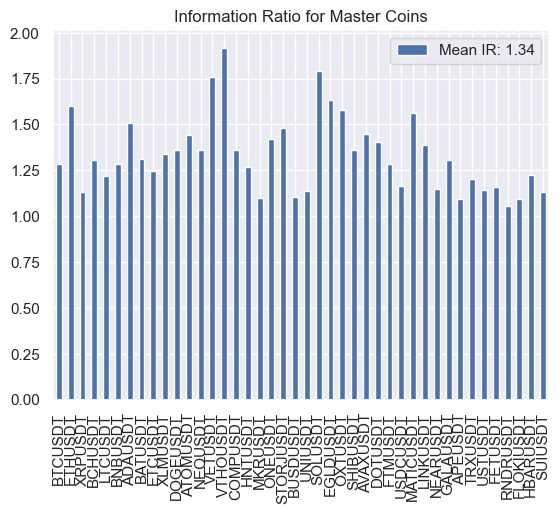

In [50]:
irs = pd.Series(info_rats, index=ret_big.columns)
irs.plot(kind='bar', title = "Information Ratio for Master Coins", 
         label = f"Mean IR: {irs.mean():.2f}")
plt.legend()